# Fine-Tuning Deep Learning Models for Voice Anti-Spoofing

### This notebook uses a two-stage process to efficiently train and improve multiple models for voice classification.

Stage 1: Initial Training. We will train three models (Baseline CNN, Deeper CNN, and ViT) from scratch. This is a long process that only needs to be run once. The trained models are then saved to disk.

Stage 2: Fine-Tuning. We will load the saved models and fine-tune them for a few extra epochs using advanced techniques like Data Augmentation and a Lower Learning Rate to combat overfitting and improve generalization. This stage is very fast.

Finally, we'll compare the results of our fine-tuned models to see which is the most effective.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# ==================================================================
# Part 0: Setup and Configuration
# ==================================================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as T
import torchvision.models as models
import torchvision.transforms as TV
from torch.amp import GradScaler, autocast

from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- Configuration for the LARGE Dataset ---
DATA_DIR = Path("prototyping_dataset") # !!! IMPORTANT: UPDATE THIS PATH !!!
BATCH_SIZE = 16
LEARNING_RATE = 0.001
INITIAL_EPOCHS = 15 # Epochs for the first long training run
FINE_TUNE_EPOCHS = 5 # Epochs for the fast fine-tuning run
TARGET_SAMPLE_RATE = 16000
TARGET_LEN_SECS = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device 💻")

C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device 💻


In [3]:
# --- Mel Spectrogram Transform (defined globally) ---
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=128
)

# --- AudioDataset Class (handles mixed file types and errors) ---
class AudioDataset(Dataset):
    def __init__(self, root_path, transform=None, target_sample_rate=TARGET_SAMPLE_RATE, target_len_secs=TARGET_LEN_SECS):
        self.root_path = Path(root_path)
        self.classes = sorted([d.name for d in self.root_path.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.target_len = target_sample_rate * target_len_secs
        
        # --- THIS IS THE FIX ---
        # Find the actual MelSpectrogram transform, whether it's standalone or inside a Sequential container
        if isinstance(transform, nn.Sequential):
            # If it's a pipeline, the MelSpectrogram is the first step
            mel_spec_transform = transform[0]
        else:
            # Otherwise, it's just the transform itself
            mel_spec_transform = transform

        # Calculate spectrogram shape once for robust error handling
        self.spec_height = mel_spec_transform.n_mels
        self.spec_width = (self.target_len // mel_spec_transform.hop_length) + 1
        # --- END FIX ---
        
        self.files = self._get_files() # Get files after other attributes are set

    def _get_files(self):
        files = []
        extensions_to_check = ["*.wav", "*.mp3"]
        print(f"Scanning {self.root_path} for {extensions_to_check} and extensionless files...")
        for cls_name in self.classes:
            class_dir = self.root_path / cls_name
            for ext in extensions_to_check:
                files.extend([(p, self.class_to_idx[cls_name]) for p in class_dir.glob(f"**/{ext}")])
            for file_path in class_dir.glob(f"**/*"):
                if file_path.is_file() and not file_path.suffix:
                     files.append((file_path, self.class_to_idx[cls_name]))
        print(f"Found {len(files)} files.")
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"--> WARNING: Skipping corrupted file: {file_path}")
            return torch.zeros(1, self.spec_height, self.spec_width), -1 

        if sample_rate != self.target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)
            
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if waveform.shape[1] > self.target_len: waveform = waveform[:, :self.target_len]
        else: waveform = torch.nn.functional.pad(waveform, (0, self.target_len - waveform.shape[1]))
            
        if self.transform:
            spectrogram = self.transform(waveform)
        else:
            # This case may not be used, but good to have
            spectrogram = waveform

        return spectrogram, label

# --- DataLoaders ---
# IMPORTANT: num_workers is set to 0 to prevent freezing issues on Windows
train_dataset = AudioDataset(root_path=DATA_DIR / "training", transform=mel_spectrogram_transform)
val_dataset = AudioDataset(root_path=DATA_DIR / "validation", transform=mel_spectrogram_transform)
test_dataset = AudioDataset(root_path=DATA_DIR / "testing", transform=mel_spectrogram_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
print(f"DataLoaders created. Found {len(train_dataset)} training files.")

Scanning prototyping_dataset\training for ['*.wav', '*.mp3'] and extensionless files...
Found 10776 files.
Scanning prototyping_dataset\validation for ['*.wav', '*.mp3'] and extensionless files...
Found 2160 files.
Scanning prototyping_dataset\testing for ['*.wav', '*.mp3'] and extensionless files...
Found 926 files.
DataLoaders created. Found 10776 training files.


In [4]:
# ==================================================================
# Reusable Training & Visualization Functions
# ==================================================================

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0
    scaler = GradScaler()
    for X, y in tqdm(dataloader, desc="Training"):
        if -1 in y: continue
        X, y = X.to(device), y.to(device)
        
        with autocast(device_type=device):
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
        
        # Check for nan loss before proceeding
        if torch.isnan(loss):
            print("--> WARNING: NaN loss detected. Skipping batch.")
            continue

        total_loss += loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        
        # --- THE FIX IS HERE ---
        # Add gradient clipping before the optimizer step
        scaler.unscale_(optimizer) # Unscale gradients before clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # --- END FIX ---

        scaler.step(optimizer)
        scaler.update()
        
        y_pred_class = torch.argmax(y_pred_logits, dim=1)
        total_acc += (y_pred_class == y).sum().item() / len(y)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Evaluating"):
            if -1 in y: continue
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            total_loss += loss.item()
            y_pred_class = torch.argmax(y_pred_logits, dim=1)
            total_acc += (y_pred_class == y).sum().item() / len(y)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def run_experiment(model, train_loader, val_loader, loss_fn, optimizer, device, epochs, scheduler=None):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    print(f"\n--- Training {model.__class__.__name__} for {epochs} epochs ---")
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        print(f"Epoch: {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < old_lr:
                print(f"    -> Learning rate reduced to {new_lr:.6f}")
    return history

def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs_range = range(1, len(history['train_acc']) + 1)
    ax1.plot(epochs_range, history['train_acc'], label='Train Accuracy', color='blue', marker='o', linestyle='--')
    ax1.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='orange', marker='o')
    ax1.set_title(f'Model Accuracy'); ax1.set_ylabel('Accuracy'); ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right'); ax1.grid(True)
    ax2.plot(epochs_range, history['train_loss'], label='Train Loss', color='blue', marker='o', linestyle='--')
    ax2.plot(epochs_range, history['val_loss'], label='Validation Loss', color='orange', marker='o')
    ax2.set_title(f'Model Loss'); ax2.set_ylabel('Loss'); ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right'); ax2.grid(True)
    fig.suptitle(f'Training History for {title}', fontsize=16); plt.show()
    
def plot_results(model, history, test_loader, loss_fn, device, model_name):
    plot_history(history, model_name)
    print(f"\n--- Final Evaluation on Test Set for {model_name} ---")
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            if -1 in y: continue
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            y_pred_class = torch.argmax(y_pred_logits, dim=1)
            all_preds.extend(y_pred_class.cpu().numpy()); all_labels.extend(y.cpu().numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    fig, ax = plt.subplots(figsize=(6, 6)); disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"Confusion Matrix for {model_name}"); plt.show()
    return test_acc

print("Reusable helper functions defined successfully.")

Reusable helper functions defined successfully.


Initializing temporary dataset for visualization...
Scanning prototyping_dataset\training for ['*.wav', '*.mp3'] and extensionless files...
Found 10776 files.


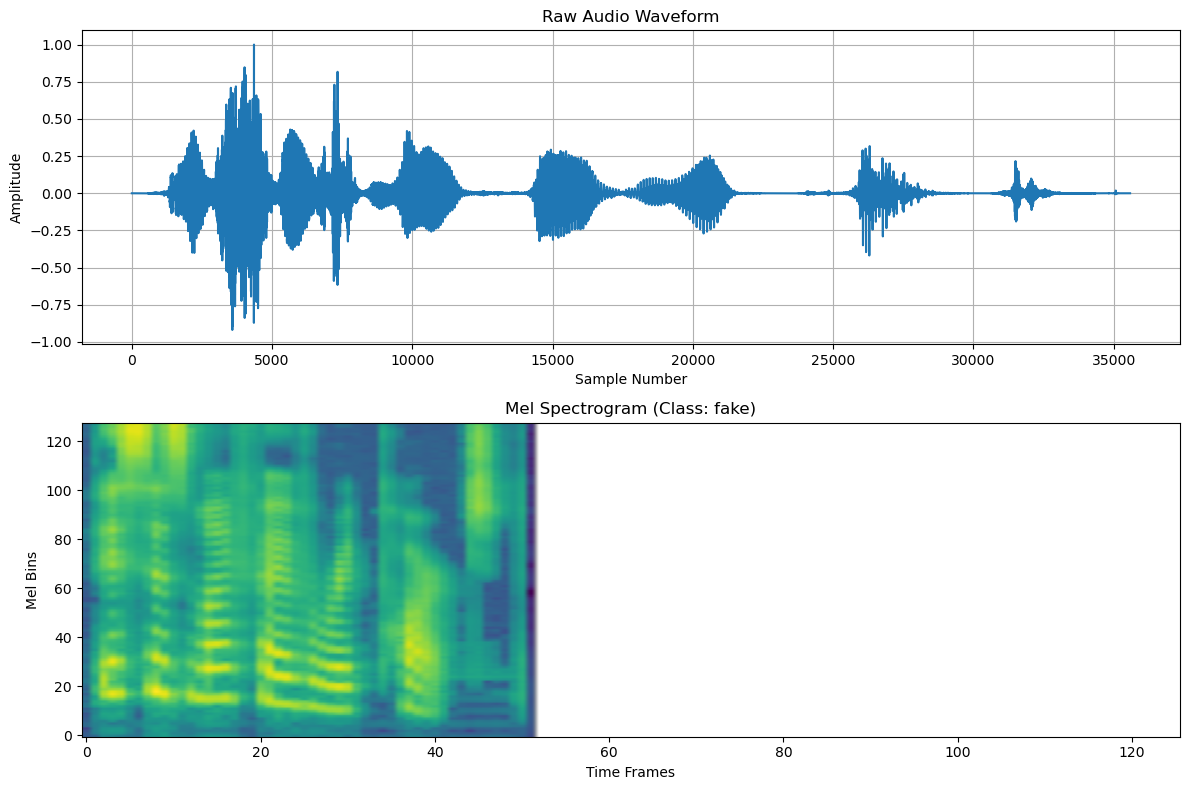

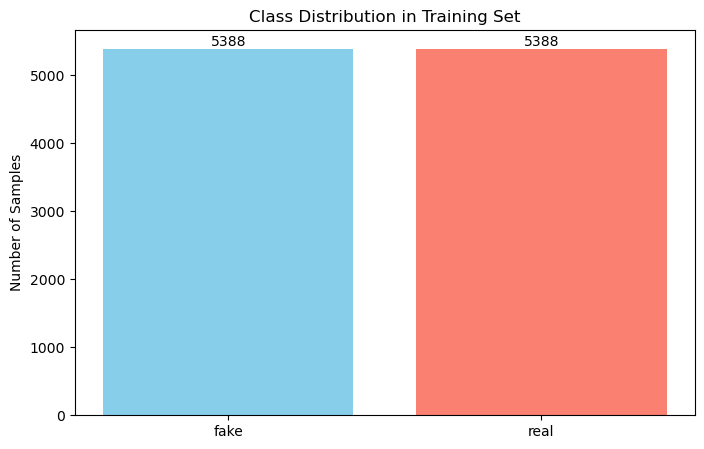

In [5]:
# --- Visualize a sample waveform and its spectrogram ---
print("Initializing temporary dataset for visualization...")
temp_dataset = AudioDataset(root_path=DATA_DIR / "training", transform=mel_spectrogram_transform)

if temp_dataset.files:
    file_info = temp_dataset.files[0]
    waveform, _ = torchaudio.load(file_info[0])
    spectrogram, label_idx = temp_dataset[0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(waveform.t().numpy())
    ax1.set_title("Raw Audio Waveform")
    ax1.set_xlabel("Sample Number"); ax1.set_ylabel("Amplitude"); ax1.grid(True)
    
    ax2.imshow(torch.log(spectrogram.squeeze()).numpy(), aspect='auto', origin='lower', cmap='viridis')
    ax2.set_title(f"Mel Spectrogram (Class: {temp_dataset.classes[label_idx]})")
    ax2.set_xlabel("Time Frames"); ax2.set_ylabel("Mel Bins")
    plt.tight_layout()
    plt.show()

    # --- Visualize class distribution ---
    class_counts = {cls: 0 for cls in temp_dataset.classes}
    for _, label_idx in temp_dataset.files:
        class_counts[temp_dataset.classes[label_idx]] += 1
        
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
    ax.set_title('Class Distribution in Training Set')
    ax.set_ylabel('Number of Samples')
    for i, count in enumerate(class_counts.values()):
        ax.text(i, count, str(count), ha='center', va='bottom')
    plt.show()
else:
    print("WARNING: No audio files found for visualization. Please check your DATA_DIR path.")

# Clean up to save memory
del temp_dataset

In [6]:
# ==================================================================
# Part 2: All Model Architectures
# ==================================================================
# All model class definitions are placed here so they can be
# accessed by both the initial training and fine-tuning sections.

class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(15360, 128), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x): return self.linear_stack(self.flatten(self.conv_stack(x)))

class DeeperCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(128 * 8 * 7, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.linear_stack(self.flatten(self.conv_stack(x)))

class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        original_conv = self.vit.conv_proj
        self.vit.conv_proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
        self.vit.conv_proj.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        self.resizer = TV.Resize((224, 224), antialias=True)
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, num_classes)
    def forward(self, x):
        return self.vit(self.resizer(x))

print("All model architectures defined successfully.")

All model architectures defined successfully.


## Stage 2: Fine-Tuning and Evaluation

Now for the fast part. We will load our saved models and fine-tune each one for just a few epochs using Data Augmentation to combat the overfitting we saw earlier.

In [7]:
# ==================================================================
# Create the Data Augmentation Pipeline and Loader
# ==================================================================
augmentation_pipeline = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=24),
    T.TimeMasking(time_mask_param=40)
)
train_transform_pipeline = torch.nn.Sequential(
    mel_spectrogram_transform,
    augmentation_pipeline
)
train_dataset_aug = AudioDataset(root_path=DATA_DIR / "training", transform=train_transform_pipeline)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)

print("Created new training dataloader with augmentation.")

Scanning prototyping_dataset\training for ['*.wav', '*.mp3'] and extensionless files...
Found 10776 files.
Created new training dataloader with augmentation.


### Fine-Tuning Model 1: Baseline CNN

In [8]:
# --- Define architecture and load saved weights ---
model_1_ft = BaselineCNN().to(device)
model_1_ft.load_state_dict(torch.load('baseline_cnn_model.pth'))

# --- Setup optimizer with lower LR and run fine-tuning ---
optimizer_1_ft = torch.optim.Adam(model_1_ft.parameters(), lr=LEARNING_RATE/10, weight_decay=1e-5)
scheduler_1_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_1_ft, 'min', patience=1)
history_1_ft = run_experiment(model_1_ft, train_loader_aug, val_loader, nn.CrossEntropyLoss(), optimizer_1_ft, device, FINE_TUNE_EPOCHS, scheduler_1_ft)

C:\Users\Reach\AppData\Local\Temp\ipykernel_20460\4080591326.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1_ft.load_state_dict(torch.load('baseline_cnn_model.pt


--- Training BaselineCNN for 5 epochs ---


Training:   4%|███▏                                                                   | 30/674 [00:05<01:37,  6.64it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  20%|██████████████▎                                                       | 138/674 [00:26<01:50,  4.84it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  25%|█████████████████▋                                                    | 170/674 [00:33<01:37,  5.18it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  28%|███████████████████▎                                                  | 186/674 [00:37<01:49,  4.44it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  32%|██████████████████████                                                | 213/674 [00:43<01:24,  5.47it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  53%|█████████████████████████████████████▎                                | 359/674 [01:15<00:58,  5.42it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  58%|████████████████████████████████████████▎                             | 388/674 [01:21<00:55,  5.11it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  62%|███████████████████████████████████████████                           | 415/674 [01:27<00:50,  5.09it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  82%|█████████████████████████████████████████████████████████▏            | 551/674 [01:56<00:24,  4.97it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  89%|██████████████████████████████████████████████████████████████        | 597/674 [02:07<00:15,  5.00it/s]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:27<00:00,  4.91it/s]


Epoch: 01 | Train Loss: 0.2760 | Train Acc: 0.9608 | Val Loss: 0.0729 | Val Acc: 0.9972


Training:   3%|██▏                                                                    | 21/674 [00:02<01:03, 10.28it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  10%|██████▉                                                                | 66/674 [00:06<01:04,  9.43it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  12%|████████▍                                                              | 80/674 [00:08<00:57, 10.28it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  16%|██████████▉                                                           | 105/674 [00:10<00:51, 11.14it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  55%|██████████████████████████████████████▍                               | 370/674 [00:36<00:34,  8.88it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  69%|████████████████████████████████████████████████▌                     | 468/674 [00:46<00:19, 10.63it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  78%|██████████████████████████████████████████████████████▊               | 528/674 [00:52<00:14, 10.05it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  84%|██████████████████████████████████████████████████████████▍           | 563/674 [00:56<00:12,  8.74it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  94%|█████████████████████████████████████████████████████████████████▋    | 633/674 [01:04<00:03, 10.75it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.45it/s]


Epoch: 02 | Train Loss: 0.1300 | Train Acc: 0.9708 | Val Loss: 0.0611 | Val Acc: 0.9972


Training:   1%|▊                                                                       | 8/674 [00:00<01:04, 10.36it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  43%|██████████████████████████████                                        | 289/674 [00:45<00:33, 11.44it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  50%|███████████████████████████████████▎                                  | 340/674 [00:49<00:30, 11.02it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  76%|█████████████████████████████████████████████████████▏                | 512/674 [01:06<00:12, 12.74it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  77%|██████████████████████████████████████████████████████                | 520/674 [01:06<00:11, 13.00it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  78%|██████████████████████████████████████████████████████▋               | 526/674 [01:07<00:12, 11.89it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  89%|██████████████████████████████████████████████████████████████        | 598/674 [01:13<00:06, 11.64it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  92%|████████████████████████████████████████████████████████████████▍     | 620/674 [01:15<00:04, 10.91it/s]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.51it/s]


Epoch: 03 | Train Loss: 0.1042 | Train Acc: 0.9739 | Val Loss: 0.0482 | Val Acc: 0.9977


Training:  12%|████████▋                                                              | 82/674 [00:08<01:01,  9.55it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  13%|█████████▏                                                             | 87/674 [00:08<00:57, 10.25it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  14%|█████████▊                                                             | 93/674 [00:09<00:49, 11.69it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  46%|███████████████████████████████▉                                      | 307/674 [00:30<00:35, 10.48it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  59%|█████████████████████████████████████████▍                            | 399/674 [00:39<00:24, 11.27it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  69%|████████████████████████████████████████████████▎                     | 465/674 [00:46<00:20, 10.27it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  70%|█████████████████████████████████████████████████▎                    | 475/674 [00:47<00:18, 10.56it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  75%|████████████████████████████████████████████████████▋                 | 507/674 [00:50<00:15, 10.52it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  91%|███████████████████████████████████████████████████████████████▍      | 611/674 [01:00<00:06, 10.05it/s]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:11<00:00, 12.15it/s]


Epoch: 04 | Train Loss: 0.0832 | Train Acc: 0.9736 | Val Loss: 0.0636 | Val Acc: 0.9977


Training:   2%|█▎                                                                     | 13/674 [00:01<01:00, 10.84it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  31%|█████████████████████▉                                                | 211/674 [00:21<00:42, 10.80it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  35%|████████████████████████▊                                             | 239/674 [00:23<00:41, 10.37it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  44%|██████████████████████████████▋                                       | 295/674 [00:29<00:35, 10.70it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  48%|█████████████████████████████████▋                                    | 324/674 [00:32<00:47,  7.37it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  65%|█████████████████████████████████████████████▎                        | 436/674 [00:44<00:24,  9.70it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  70%|█████████████████████████████████████████████████                     | 472/674 [00:48<00:20,  9.99it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  71%|█████████████████████████████████████████████████▋                    | 478/674 [00:49<00:18, 10.51it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  73%|██████████████████████████████████████████████████▉                   | 490/674 [00:50<00:16, 11.03it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  97%|███████████████████████████████████████████████████████████████████▉  | 654/674 [01:07<00:01, 10.00it/s]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:12<00:00, 10.92it/s]

Epoch: 05 | Train Loss: 0.0748 | Train Acc: 0.9728 | Val Loss: 0.0499 | Val Acc: 0.9972
    -> Learning rate reduced to 0.000010


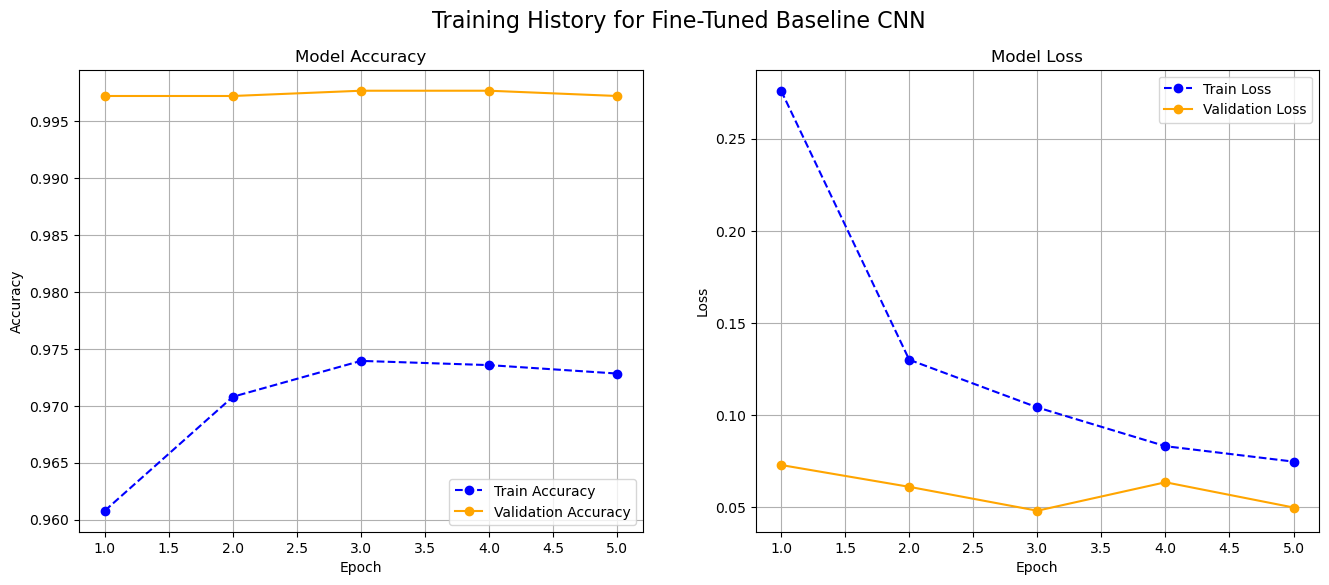


--- Final Evaluation on Test Set for Fine-Tuned Baseline CNN ---


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:12<00:00,  4.63it/s]


Test Accuracy: 0.7198 | Test Loss: 9.9771


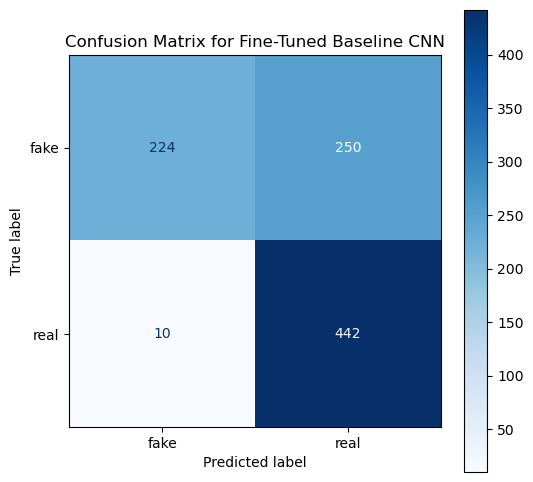

Saved fine-tuned model.


In [9]:
# --- Visualize Fine-Tuned Baseline CNN Results ---
acc_1_ft = plot_results(model_1_ft, history_1_ft, test_loader, nn.CrossEntropyLoss(), device, "Fine-Tuned Baseline CNN")
torch.save(model_1_ft.state_dict(), 'baseline_cnn_finetuned.pth')
print("Saved fine-tuned model.")

### Fine-Tuning Model 2: Deeper CNN

In [12]:
# --- Define architecture and load saved weights ---
model_2_ft = DeeperCNN().to(device)
model_2_ft.load_state_dict(torch.load('deeper_cnn_model.pth'))

# --- Setup optimizer with lower LR and run fine-tuning ---
optimizer_2_ft = torch.optim.Adam(model_2_ft.parameters(), lr=LEARNING_RATE/10, weight_decay=1e-5)
scheduler_2_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_2_ft, 'min', patience=1)
history_2_ft = run_experiment(model_2_ft, train_loader_aug, val_loader, nn.CrossEntropyLoss(), optimizer_2_ft, device, FINE_TUNE_EPOCHS, scheduler_2_ft)

C:\Users\Reach\AppData\Local\Temp\ipykernel_20460\2880146114.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_2_ft.load_state_dict(torch.load('deeper_cnn_model.pth'


--- Training DeeperCNN for 5 epochs ---


Training:  43%|█████████████████████████████▊                                        | 287/674 [00:23<00:29, 12.97it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  61%|██████████████████████████████████████████▌                           | 410/674 [00:34<00:25, 10.35it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  87%|█████████████████████████████████████████████████████████████         | 588/674 [00:50<00:05, 14.48it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  89%|██████████████████████████████████████████████████████████████▎       | 600/674 [00:51<00:06, 12.33it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.88it/s]


Epoch: 01 | Train Loss: 0.2573 | Train Acc: 0.9675 | Val Loss: nan | Val Acc: 0.5000


Training:  31%|█████████████████████▊                                                | 210/674 [00:17<00:35, 13.03it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  53%|████████████████████████████████████▊                                 | 355/674 [00:30<00:27, 11.64it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  62%|███████████████████████████████████████████                           | 415/674 [00:35<00:20, 12.53it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  70%|████████████████████████████████████████████████▊                     | 470/674 [00:40<00:20,  9.85it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  79%|███████████████████████████████████████████████████████▎              | 533/674 [00:47<00:13, 10.34it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  88%|█████████████████████████████████████████████████████████████▍        | 592/674 [00:52<00:07, 11.19it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:16<00:00,  8.17it/s]


Epoch: 02 | Train Loss: 0.0912 | Train Acc: 0.9748 | Val Loss: nan | Val Acc: 0.5000
    -> Learning rate reduced to 0.000010


Training:  41%|████████████████████████████▊                                         | 277/674 [00:25<00:30, 13.09it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  44%|██████████████████████████████▊                                       | 297/674 [00:26<00:29, 12.71it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  75%|████████████████████████████████████████████████████▎                 | 504/674 [00:46<00:10, 15.78it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  82%|█████████████████████████████████████████████████████████             | 550/674 [00:49<00:09, 13.70it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  85%|███████████████████████████████████████████████████████████▌          | 574/674 [00:52<00:09, 10.11it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  88%|█████████████████████████████████████████████████████████████▍        | 592/674 [00:53<00:07, 11.13it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.33it/s]


Epoch: 03 | Train Loss: 0.0618 | Train Acc: 0.9767 | Val Loss: nan | Val Acc: 0.5000


Training:   4%|██▋                                                                    | 25/674 [00:02<00:58, 11.05it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  69%|████████████████████████████████████████████████▎                     | 465/674 [00:43<00:21,  9.94it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  78%|██████████████████████████████████████████████████████▊               | 528/674 [00:49<00:11, 12.26it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  93%|█████████████████████████████████████████████████████████████████▍    | 630/674 [00:57<00:03, 11.56it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  95%|██████████████████████████████████████████████████████████████████▋   | 642/674 [00:58<00:02, 13.70it/s]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.26it/s]


Epoch: 04 | Train Loss: 0.0657 | Train Acc: 0.9782 | Val Loss: nan | Val Acc: 0.5000
    -> Learning rate reduced to 0.000001


Training:   1%|▊                                                                       | 8/674 [00:00<00:52, 12.68it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  18%|████████████▍                                                         | 120/674 [00:09<00:43, 12.84it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  58%|████████████████████████████████████████▎                             | 388/674 [00:32<00:25, 11.05it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  66%|██████████████████████████████████████████████▏                       | 445/674 [00:37<00:20, 11.39it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  80%|████████████████████████████████████████████████████████▏             | 541/674 [00:45<00:15,  8.54it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  86%|████████████████████████████████████████████████████████████▍         | 582/674 [00:49<00:06, 14.80it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.19it/s]

Epoch: 05 | Train Loss: 0.0621 | Train Acc: 0.9771 | Val Loss: nan | Val Acc: 0.5000


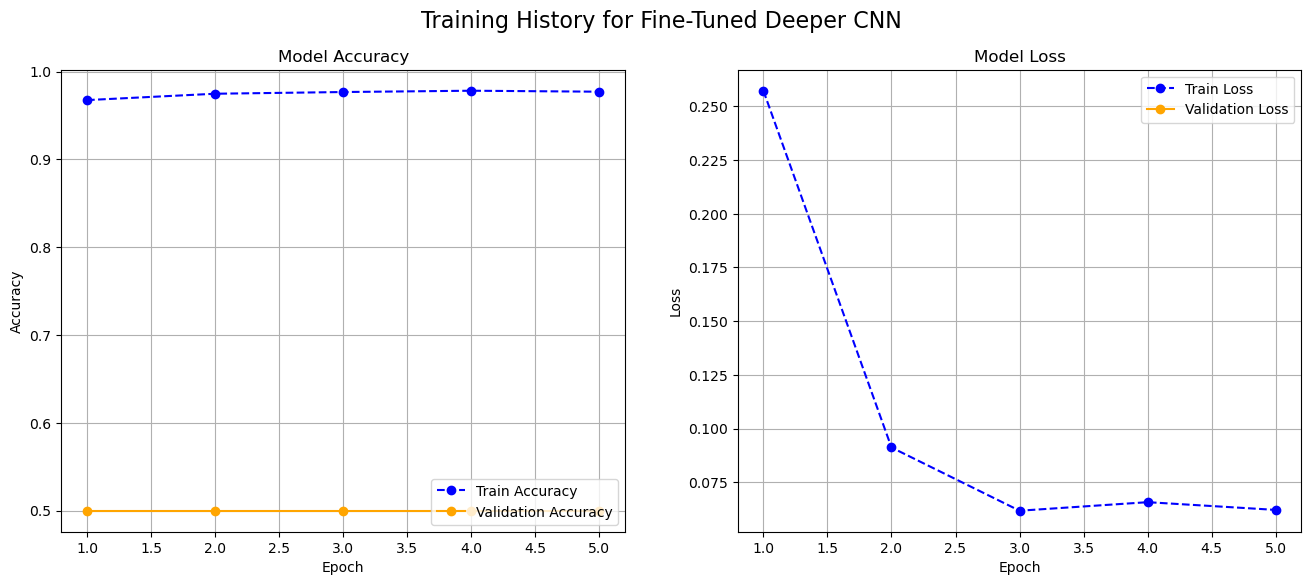


--- Final Evaluation on Test Set for Fine-Tuned Deeper CNN ---


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 58/58 [00:03<00:00, 18.27it/s]


Test Accuracy: 0.5108 | Test Loss: nan


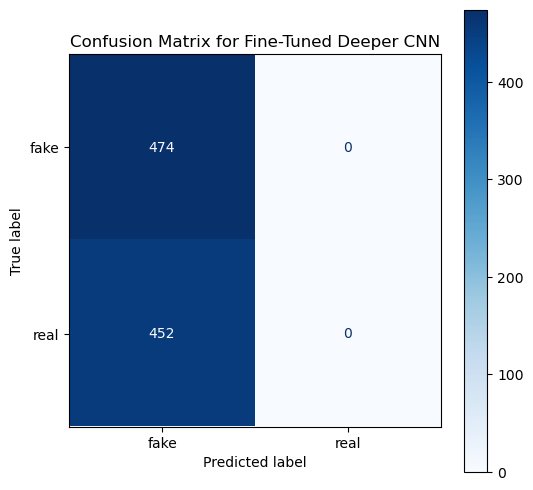

Saved fine-tuned model.


In [13]:
# --- Visualize Fine-Tuned Deeper CNN Results ---
acc_2_ft = plot_results(model_2_ft, history_2_ft, test_loader, nn.CrossEntropyLoss(), device, "Fine-Tuned Deeper CNN")
torch.save(model_2_ft.state_dict(), 'deeper_cnn_finetuned.pth')
print("Saved fine-tuned model.")

### Fine-Tuning Model 3: Vision Transformer (ViT)

In [15]:
# --- Define architecture and load saved weights ---
model_3_ft = ViTModel().to(device)
model_3_ft.load_state_dict(torch.load('vit_model.pth'))

# --- Setup optimizer with very low LR and run fine-tuning ---
optimizer_3_ft = torch.optim.Adam(model_3_ft.parameters(), lr=LEARNING_RATE/100, weight_decay=1e-5)
scheduler_3_ft = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_3_ft, 'min', patience=1)
history_3_ft = run_experiment(model_3_ft, train_loader_aug, val_loader, nn.CrossEntropyLoss(), optimizer_3_ft, device, FINE_TUNE_EPOCHS, scheduler_3_ft)

C:\Users\Reach\AppData\Local\Temp\ipykernel_20460\653182683.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_3_ft.load_state_dict(torch.load('vit_model.pth'))



--- Training ViTModel for 5 epochs ---


Training:   3%|██▍                                                                    | 23/674 [00:07<03:34,  3.03it/s]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:   4%|██▉                                                                    | 28/674 [00:08<02:42,  3.96it/s]

--> WARNING: NaN loss detected. Skipping batch.


Training:  14%|██████████▏                                                            | 97/674 [02:01<14:51,  1.55s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  18%|████████████▎                                                         | 118/674 [02:31<11:39,  1.26s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  20%|██████████████                                                        | 135/674 [03:00<11:07,  1.24s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  21%|██████████████▌                                                       | 140/674 [03:09<12:01,  1.35s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  36%|█████████████████████████                                             | 241/674 [07:31<36:36,  5.07s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  36%|█████████████████████████▎                                            | 244/674 [07:38<21:40,  3.02s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  37%|██████████████████████████▏                                           | 252/674 [07:51<09:35,  1.36s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  53%|█████████████████████████████████████                                 | 357/674 [10:30<06:23,  1.21s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  60%|██████████████████████████████████████████▎                           | 407/674 [11:48<06:37,  1.49s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  68%|███████████████████████████████████████████████▌                      | 458/674 [13:02<04:23,  1.22s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  82%|█████████████████████████████████████████████████████████▋            | 556/674 [15:30<02:23,  1.22s/it]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [05:24<00:00,  2.41s/it]


Epoch: 01 | Train Loss: 0.0684 | Train Acc: 0.9605 | Val Loss: 0.0042 | Val Acc: 0.9986


Training:   5%|███▍                                                                   | 33/674 [00:51<13:51,  1.30s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:   7%|█████▏                                                                 | 49/674 [01:17<12:00,  1.15s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  18%|████████████▌                                                         | 121/674 [03:09<12:00,  1.30s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  33%|██████████████████████▉                                               | 221/674 [05:50<09:52,  1.31s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  34%|███████████████████████▋                                              | 228/674 [06:03<10:43,  1.44s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  35%|████████████████████████▏                                             | 233/674 [06:14<11:36,  1.58s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  42%|█████████████████████████████▏                                        | 281/674 [07:32<08:37,  1.32s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  52%|████████████████████████████████████▌                                 | 352/674 [09:26<06:12,  1.16s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  57%|███████████████████████████████████████▉                              | 385/674 [10:18<06:18,  1.31s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  73%|███████████████████████████████████████████████████▍                  | 495/674 [13:14<03:26,  1.16s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  84%|██████████████████████████████████████████████████████████▉           | 568/674 [15:09<02:18,  1.31s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  91%|███████████████████████████████████████████████████████████████▎      | 610/674 [16:17<01:23,  1.30s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  97%|███████████████████████████████████████████████████████████████████▋  | 652/674 [17:26<00:28,  1.31s/it]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [05:09<00:00,  2.29s/it]


Epoch: 02 | Train Loss: 0.0312 | Train Acc: 0.9710 | Val Loss: 0.0038 | Val Acc: 0.9977


Training:  11%|███████▌                                                               | 72/674 [01:47<14:52,  1.48s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  12%|████████▋                                                              | 83/674 [02:01<11:46,  1.20s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  24%|████████████████▋                                                     | 161/674 [04:00<12:36,  1.48s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  37%|█████████████████████████▊                                            | 249/674 [06:07<08:31,  1.20s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  37%|██████████████████████████                                            | 251/674 [06:11<10:19,  1.46s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  40%|████████████████████████████▏                                         | 272/674 [06:43<08:05,  1.21s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  44%|██████████████████████████████▌                                       | 294/674 [07:18<07:37,  1.20s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  57%|███████████████████████████████████████▌                              | 381/674 [09:29<05:54,  1.21s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  69%|████████████████████████████████████████████████▌                     | 468/674 [11:40<04:09,  1.21s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  72%|██████████████████████████████████████████████████▎                   | 485/674 [12:09<04:24,  1.40s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  76%|█████████████████████████████████████████████████████▎                | 513/674 [12:56<04:17,  1.60s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  81%|████████████████████████████████████████████████████████▌             | 545/674 [13:45<02:43,  1.27s/it]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [05:35<00:00,  2.48s/it]


Epoch: 03 | Train Loss: 0.0200 | Train Acc: 0.9748 | Val Loss: 0.0043 | Val Acc: 0.9981


Training:  20%|█████████████▊                                                        | 133/674 [03:40<12:49,  1.42s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  21%|██████████████▌                                                       | 140/674 [03:54<13:09,  1.48s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  33%|███████████████████████                                               | 222/674 [06:09<10:01,  1.33s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  34%|███████████████████████▋                                              | 228/674 [06:21<10:13,  1.38s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training:  41%|████████████████████████████▉                                         | 279/674 [07:43<08:55,  1.36s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  42%|█████████████████████████████▏                                        | 281/674 [07:47<09:23,  1.44s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  53%|█████████████████████████████████████▍                                | 360/674 [29:06<09:42,  1.86s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  65%|█████████████████████████████████████████████▌                        | 439/674 [31:40<06:11,  1.58s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  69%|████████████████████████████████████████████████▎                     | 465/674 [32:32<05:28,  1.57s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  99%|█████████████████████████████████████████████████████████████████████▍| 668/674 [39:02<00:09,  1.57s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training: 100%|█████████████████████████████████████████████████████████████████████▊| 672/674 [39:11<00:03,  1.72s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [08:21<00:00,  3.71s/it]


Epoch: 04 | Train Loss: 0.0212 | Train Acc: 0.9772 | Val Loss: 0.0036 | Val Acc: 0.9977


Training:   3%|██▏                                                                    | 21/674 [00:36<14:52,  1.37s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  13%|████████▉                                                              | 85/674 [02:34<17:35,  1.79s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file15746.mp3


Training:  16%|███████████▏                                                          | 108/674 [03:12<13:49,  1.47s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  29%|████████████████████▎                                                 | 195/674 [05:50<11:41,  1.47s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  43%|██████████████████████████████                                        | 290/674 [08:41<09:19,  1.46s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  49%|██████████████████████████████████▍                                   | 332/674 [09:58<08:18,  1.46s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  69%|███████████████████████████████████████████████▉                      | 462/674 [13:54<06:20,  1.79s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file5323.mp3


Training:  75%|████████████████████████████████████████████████████▊                 | 508/674 [15:13<04:01,  1.46s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  92%|████████████████████████████████████████████████████████████████      | 617/674 [18:30<01:23,  1.46s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  95%|██████████████████████████████████████████████████████████████████▍   | 640/674 [19:13<00:49,  1.45s/it]

--> WARNING: NaN loss detected. Skipping batch.


Training:  98%|████████████████████████████████████████████████████████████████████▌ | 660/674 [19:52<00:24,  1.77s/it]

--> WARNING: Skipping corrupted file: prototyping_dataset\training\fake\file27839.mp3


Training: 100%|█████████████████████████████████████████████████████████████████████▊| 672/674 [20:10<00:02,  1.45s/it]

--> WARNING: NaN loss detected. Skipping batch.


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 135/135 [08:19<00:00,  3.70s/it]

Epoch: 05 | Train Loss: 0.0165 | Train Acc: 0.9764 | Val Loss: 0.0044 | Val Acc: 0.9986


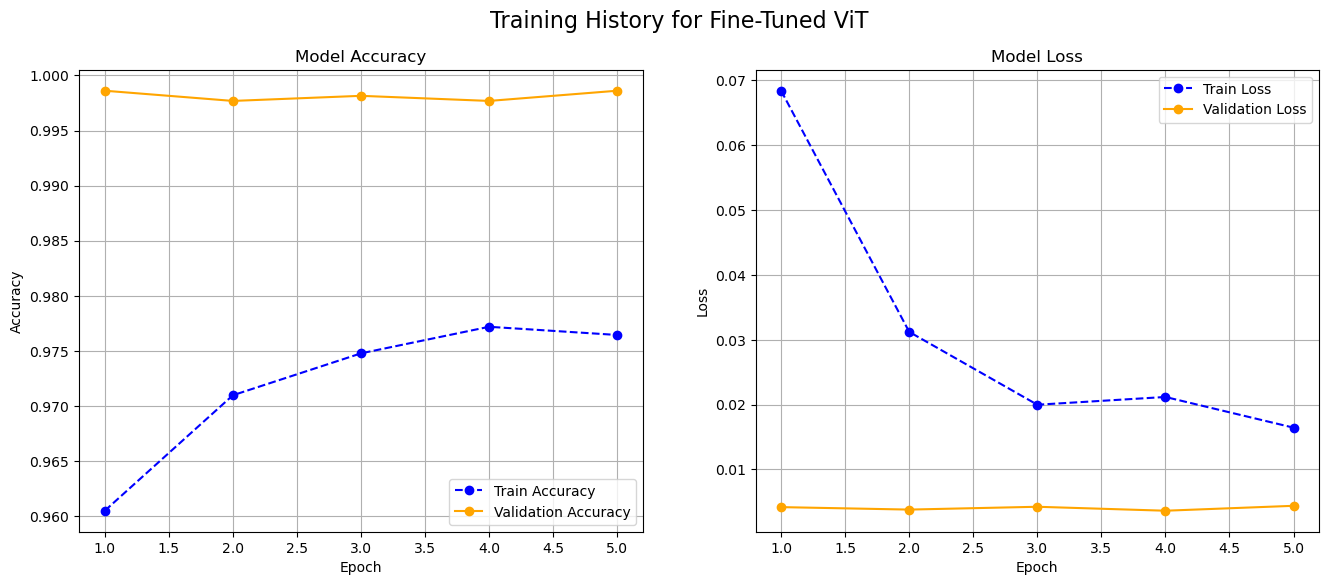


--- Final Evaluation on Test Set for Fine-Tuned ViT ---


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 58/58 [03:40<00:00,  3.80s/it]


Test Accuracy: 0.6562 | Test Loss: 1.8949


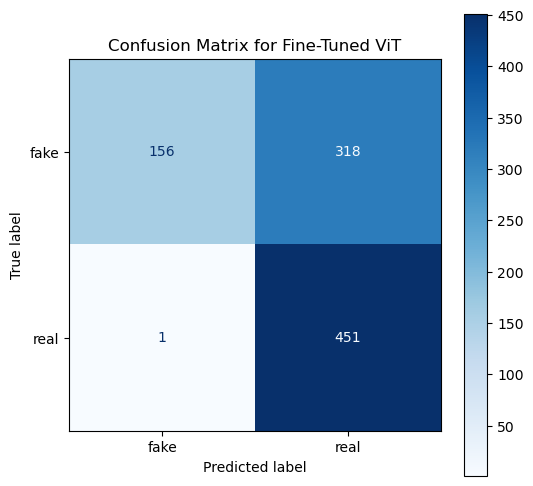

Saved fine-tuned model.


In [18]:
# --- Visualize Fine-Tuned ViT Results ---
acc_3_ft = plot_results(model_3_ft, history_3_ft, test_loader, nn.CrossEntropyLoss(), device, "Fine-Tuned ViT")
torch.save(model_3_ft.state_dict(), 'vit_finetuned.pth')
print("Saved fine-tuned model.")

## Final Comparison

### After fine-tuning all three models, we can compare their final performance on the unseen test data.

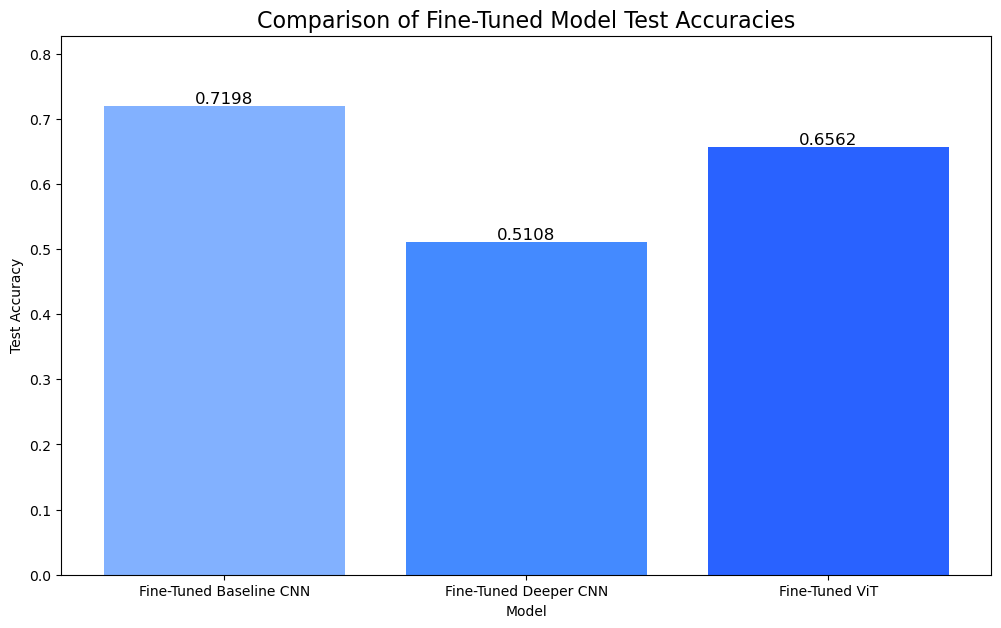

In [19]:
# ==================================================================
# Part 5: Final Model Comparison
# ==================================================================
model_names = ["Fine-Tuned Baseline CNN", "Fine-Tuned Deeper CNN", "Fine-Tuned ViT"]
test_accuracies = [acc_1_ft, acc_2_ft, acc_3_ft]

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.bar(model_names, test_accuracies, color=['#82B1FF', '#448AFF', '#2962FF'])
ax.set_title('Comparison of Fine-Tuned Model Test Accuracies', fontsize=16)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Model')
ax.set_ylim(0, max(test_accuracies) * 1.15 if test_accuracies else 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12) 

plt.show()